In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


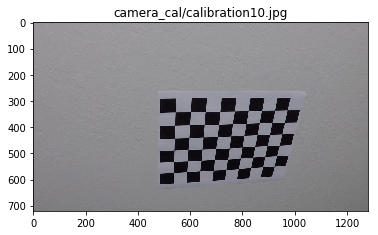

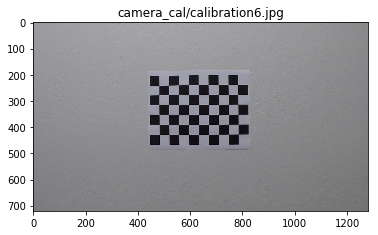

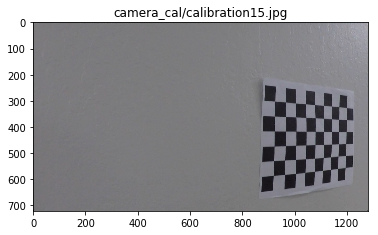

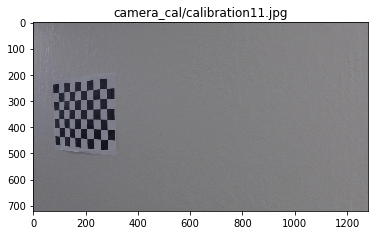

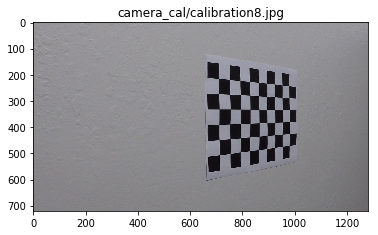

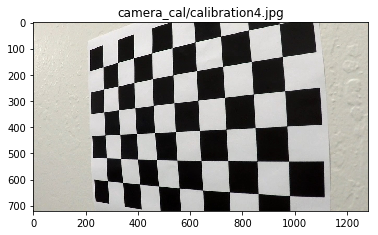

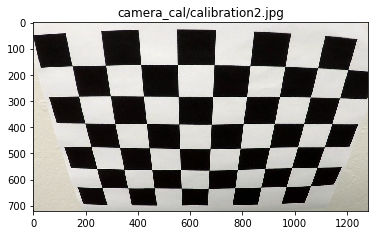

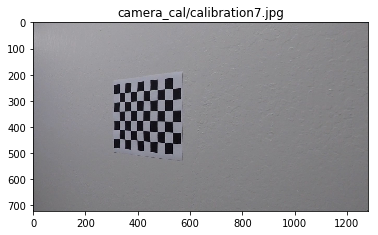

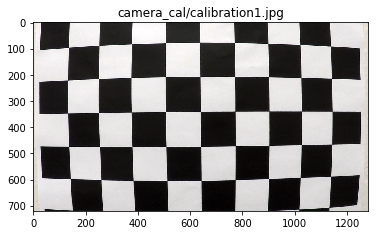

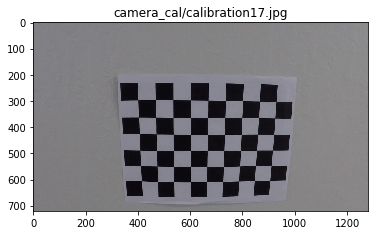

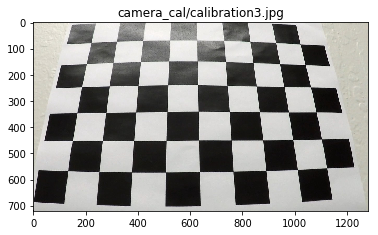

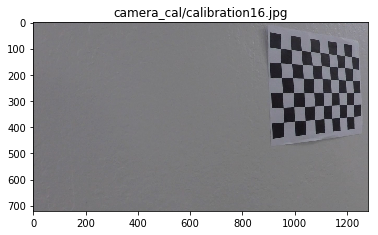

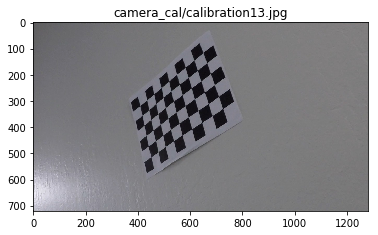

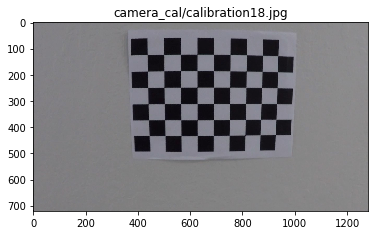

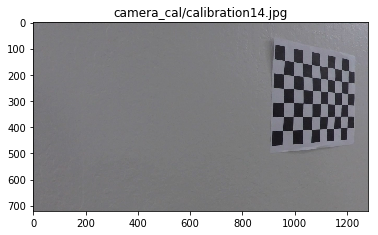

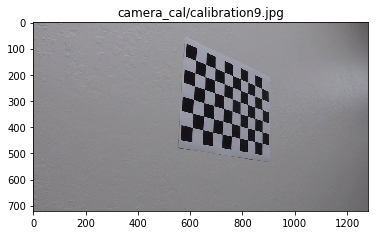

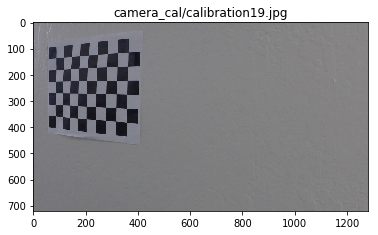

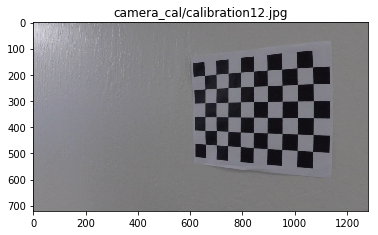

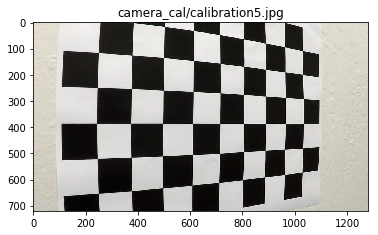

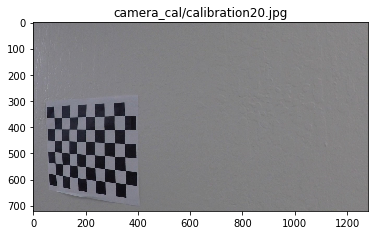

In [2]:
images = glob.glob('camera_cal/calibration*.jpg')

for fname in images :
    img = cv2.imread(fname)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.title(fname)
    plt.show()


In [123]:
import pickle
dist_pickle = pickle.load(open( "camera_cal.p", "rb" ))

def processImage(img, sobelx_thres=(20, 100), s_thres = (170, 255)):
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = sobelx_thres[0]
    thresh_max = sobelx_thres[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = s_thres[0]
    s_thresh_max = s_thres[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary*255)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    plt.show()

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    view = np.dstack((combined_binary, combined_binary, combined_binary))*255
    img_size = (view.shape[1], view.shape[0])

    slope = (680.-430.) / (265.-628.)
    ydes = 480
    xdes = int((ydes-680.) / slope + 265.)

    slope2 = (430.-680.) / (655.-1045.)
    xdes2 = int((ydes-680.)/slope2 + 1045.)

    src = np.float32([[265, 680], [xdes, ydes], [xdes2, ydes], [1045, 680]])
    dst = np.float32([[400, 700], [400, 200], [880, 200], [880, 700]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    thickness=2
    cv2.line(view, (src[0][0], src[0][1]), (src[1][0], src[1][1]), [0, 255, 0], thickness)
    cv2.line(view, (src[3][0], src[3][1]), (src[2][0], src[2][1]), [0, 255, 0], thickness)
    cv2.line(view, (src[1][0], src[1][1]), (src[2][0], src[2][1]), [0, 255, 0], thickness)
    ax1.imshow(view)
    
    warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)

    warpedimg = np.dstack((warped, warped, warped))*255
    cv2.line(warpedimg, (dst[0][0], dst[0][1]), (dst[1][0], dst[1][1]), [0, 255, 0], thickness)
    cv2.line(warpedimg, (dst[3][0], dst[3][1]), (dst[2][0], dst[2][1]), [0, 255, 0], thickness)

    ax2.imshow(warpedimg)
    plt.show()

    return img


(720, 1280, 3)


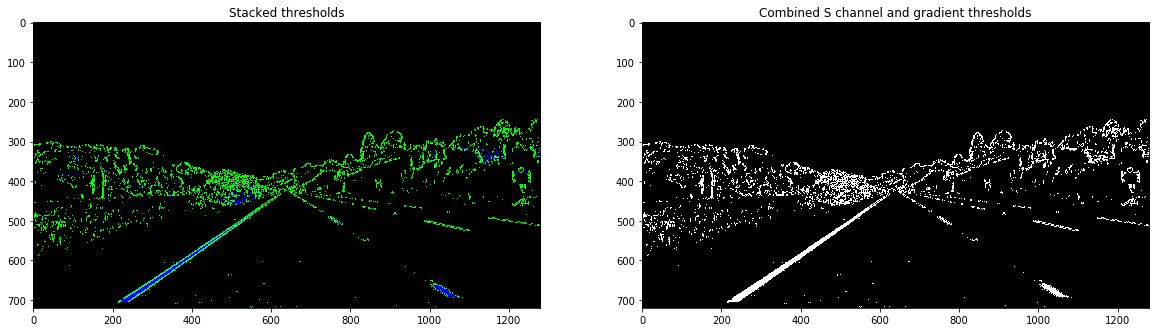

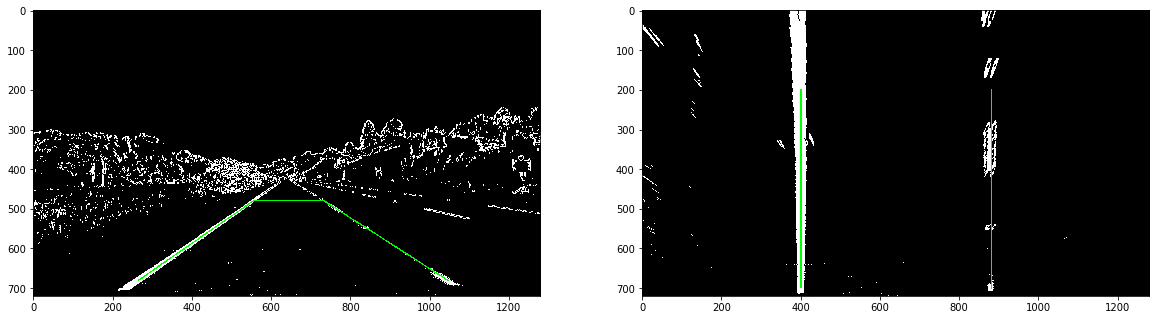

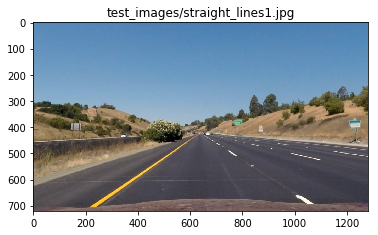

In [124]:
fname = "test_images/straight_lines1.jpg"
img = cv2.imread(fname)
print(img.shape)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = processImage(rgb)
plt.imshow(dst)
plt.title(fname)
plt.show()



camera_cal/calibration1.jpg


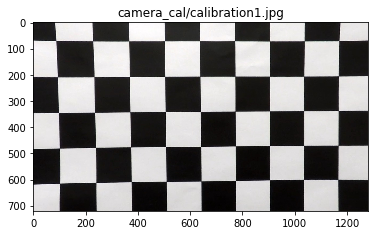

In [5]:
fname = images[8]
print(fname)
img = cv2.imread(fname)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = processImage(rgb)
plt.imshow(dst)
plt.title(fname)
plt.show()


In [ ]:
from moviepy.editor import VideoFileClip

white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

